# 03 - Interactive Viz

To visualise the notebook with the maps, please click on this link : <br>
http://nbviewer.jupyter.org/github/emlg/ada/blob/master/Homework3/ADA-Homework3.ipynb?flush_cache=true <br>

NOTE : Some maps have 2 layers, both are activated, please untick the one you are not interested with.

In [1]:
#Usefull imports
import numpy as np
import pandas as pd
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm

## Exercice 1

On the eurostat website, we looked at the Data Navigation Tree, after selecting 'Population and social conditions', we found the 'Labour market' and access the 'Employment and unemployment'. We chose the 'LFS main indicators' category and the 'Unemployment by sex and age - monthly average' file. In the settings we selected the month of July 2017 and data in percentage of active population and in thousand of persons. We also did not consider the European averages and the values for the United States and Japan. We selected the monthly values as we are asked to get recent values and this was the closest date we could have with no missing values. Indeed August and September data are also available although some countries have missing values (displayed as ':' in the file).

In [2]:
#First we load the file in a DataFrame
euro_df = pd.DataFrame.from_csv('eurostat-July17.csv')
#Then we get rid of useless columns 
#(SEX is useless as we chose to keep only the Total, same for AGE)
euro_df = euro_df.drop(['SEX', 'AGE', 'S_ADJ', 'Flag and Footnotes'], 1)

In [3]:
#For your information here is an example of data for one country
euro_df[euro_df['GEO'] == 'Iceland']

,GEO,UNIT,Value
TIME,,,
2017M07,Iceland,Thousand persons,"5,660"
2017M07,Iceland,Percentage of active population,2.9


In [4]:
#Process Dataframe to get the values corresponding to the given type
def value_type_df(value_type):
    #Select the correct value type rows
    tmp_df = euro_df[euro_df['UNIT'] == value_type]
    #Get rid of the unnecessary columns
    tmp_df = tmp_df[['GEO', 'Value']]
    tmp_df = tmp_df.reset_index().drop('TIME', 1)
    #Correct Germany name
    tmp_df['GEO'][tmp_df['GEO'] == "Germany (until 1990 former territory of the FRG)"] = "Germany"
    #Discard unknown values (not necessary for our dataset)
    res_df = tmp_df[tmp_df['Value'] != ':']
    #Cast the values to float
    res_df.Value = res_df.Value.apply(lambda x : x.replace(',','.'))
    res_df.Value = res_df.Value.astype(float)
    return res_df

In [5]:
country_percentage = value_type_df('Percentage of active population')
country_percentage.head()

,GEO,Value
0,Belgium,7.3
1,Bulgaria,6.1
2,Czech Republic,2.8
3,Denmark,5.8
4,Germany,3.7


We plot the values of the sub-dataframes to gain insights as how we should display them

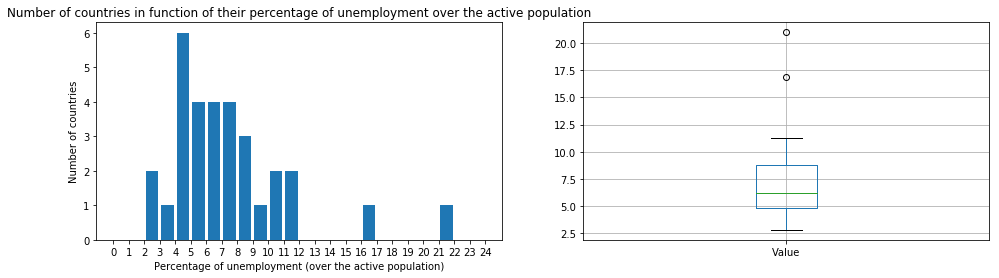

In [6]:
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.subplot(121)
plt.hist(country_percentage['Value'], bins = range(0,25, 1), align='mid', rwidth = 0.8)
plt.title("Number of countries in function of their percentage of unemployment over the active population")
plt.xlabel("Percentage of unemployment (over the active population)")
plt.ylabel("Number of countries")
plt.xticks(range(0, 25, 1))

plt.subplot(122)
country_percentage.boxplot()
plt.show()

Given the above visualisation, we have that values lie between 2 and 22. So we decided to split this range in intervals from 0 to 25 with width 5. <br>
We made this choice as we feel a linear scale would not have to many close, and so indistinguishable, values. Afterwards having a 5-step scale lets us have a middle point. The width of 5 is chose as viewers can easily represent themselves the value of 5% (rather than 3%). <br>
We chose the orange scale as we consider having a high percentage of unemployment is a danger, so it tend to be red. 

In [7]:
percentage_step = cm.StepColormap(['#ffffd4','#fed98e','#fe9929','#d95f0e','#993404'], 
                                  vmin = 0, vmax = 25, index =[0,5,10,15,20,25], 
    caption= 'Percentage of unemployment over the active population in Europe in July 2017(in %)')
percentage_step

In [8]:
#Define the color function for percentage data
def perc_color_function(feature):
    country = feature['properties']['NAME']
    tmp_df = country_percentage[country_percentage['GEO'] == country]
    #We handle the case of missing values (That is to say a country not in our dataframe)
    if len(tmp_df) > 0:
        perc = float(tmp_df['Value'])
        return percentage_step(perc)
    else:
        #We select a gray color for unknown value as
        return '#DDDDDD'

After trying the first version of our map we thought that it would be nice to be able to switch from the view of unemployment as percentage to the view of unemployment as thousands of persons. <br>
We created the sub-Dataframe and did the analysis to chose which color scale to use.

In [9]:
#Create the dataframe of country to thousand persons unemployed
country_thousand = value_type_df('Thousand persons')
country_thousand.head()

,GEO,Value
0,Belgium,363.000
1,Bulgaria,206.000
2,Czech Republic,153.000
3,Denmark,172.000
4,Germany,1.583


We see a recurrent pattern in the above dataframe in the 'Value' column: 
    - If it is of the form 363.000 (Belgium) with the .000,  it is in thousands
    - If it is of the form 1.583 (Germany), it is in millions; except for Iceland: 5.660 because it can't be 5 millions
We will modify this in the dataframe with the following function that multiply the values of the second category by 1000 in order that all values are of the same order.

In [10]:
def convert_to_millions(df, column_name):
    column = np.copy(df[column_name])
    ### Get index of Iceland in the dataframe as we don't want to modify its value
    index_Iceland = country_thousand.index[country_thousand['GEO'] == 'Iceland'].tolist()[0]
    ### Get indices of numbers we need to express in millions (with decimal value different of 0) except Iceland
    indices_to_multiply = [index for index, value in enumerate(column) 
                           if ((int(value) - value != 0.0) and index != index_Iceland)]
    column[indices_to_multiply] *= 1000 
    df[column_name] = column
    return df

country_thousand = convert_to_millions(country_thousand, 'Value')
country_thousand.head()

,GEO,Value
0,Belgium,363.0
1,Bulgaria,206.0
2,Czech Republic,153.0
3,Denmark,172.0
4,Germany,1583.0


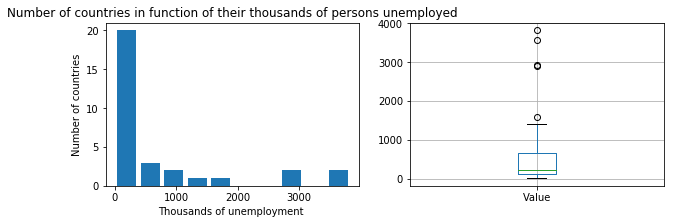

In [11]:
fig2 = plt.figure()
fig2.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(country_thousand['Value'],  align='mid', rwidth = 0.8)
plt.title("Number of countries in function of their thousands of persons unemployed")
plt.xlabel("Thousands of unemployment ")
plt.ylabel("Number of countries")

plt.subplot(122)
country_thousand.boxplot()
plt.show()

In [12]:
thousand_step = cm.StepColormap(['#ffffd4','#a1dab4','#41b6c4','#2c7fb8', '#253494'], 
                        vmin =0, vmax = max(country_thousand['Value']),
                        caption = 'Thousands of unemployed persons in Europe in July 2017')
thousand_step

In [13]:
#Define the color of data in thousand of person data
def thousand_color_function(feature):
    country = feature['properties']['NAME']
    tmp_df = country_thousand[country_thousand['GEO'] == country]
    #We handle the case of missing values (That is to say a country not in our dataframe)
    if len(tmp_df) > 0:
        thousand = float(tmp_df['Value'])
        return thousand_step(thousand)
    else:
       #We select a gray color for unknown value as
        return '#DDDDDD'

We load the data to draw the map, note the topojson file.

In [14]:
europe_json_data = json.load(open(r'topojson/europe.topojson.json'))

Use the TopoJson method from folium (instead as the GeoJson) as we have the topojson files.  
The countries that appear lightblue/white have unknown percentage

In [15]:
m_europe = folium.Map([55,15], tiles = 'cartodbpositron', zoom_start = 4)

folium.TopoJson(
    europe_json_data,
    'objects.europe',
    name='Percentages',    
    style_function= lambda feature: {
        'fillColor': perc_color_function(feature),
        'fillOpacity':0.8,
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_europe)
m_europe.add_child(percentage_step)

folium.TopoJson(
    europe_json_data,
    'objects.europe',
    name='Thousands',    
    style_function= lambda feature: {
        'fillColor': thousand_color_function(feature),
        'fillOpacity': 0.8,
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_europe)
m_europe.add_child(thousand_step)

folium.LayerControl(collapsed = False).add_to(m_europe)
m_europe

Recall that the data is coming from july 2017 and that the unemployement rate is the number of unemployed people which are part of the active population (so employed people looking for another job are not counted). At this time, this kind of unemployement rate in Switzerland was around 2.05% (we use the data of exercise 2 to trivialy calculate this) which is very low compared to the other rates that we can find in Europe. In terms of unemployement rate, Switzerland has, in fact, the lowest unemployement rate in Europe, even beating the Czech Republic (2.8%) and Iceland (2.9%).


For a better insight on the actual values for each country, we provide a barchart of the unemployement rate per country
and another one of the number of unemployed persons per country.

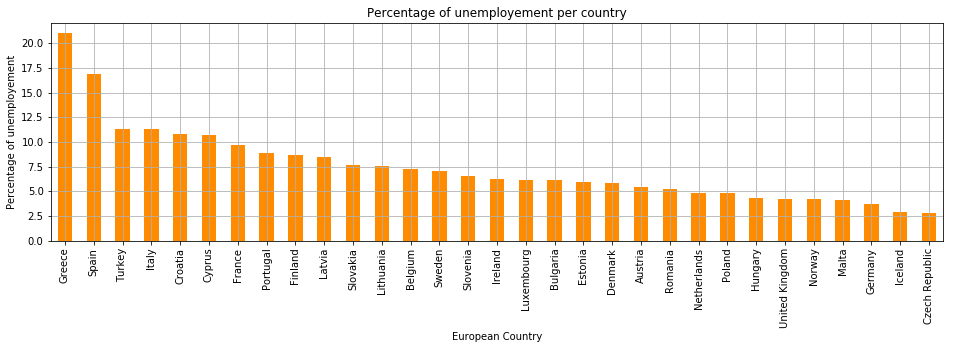

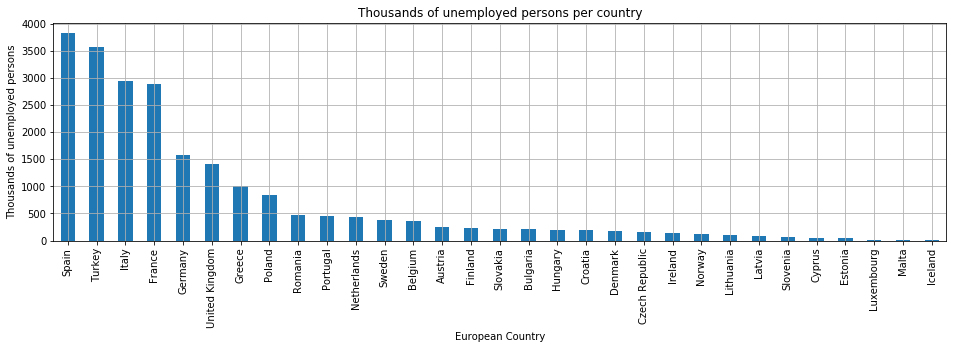

In [16]:
barplot1 = country_percentage.sort_values(by='Value', ascending = False).plot.bar(x='GEO', y='Value', legend=False, figsize=(16, 4), grid=True, color='DarkOrange')
barplot1.set_title('Percentage of unemployement per country')
barplot1.set_xlabel('European Country')
barplot1.set_ylabel('Percentage of unemployement')

barplot2 = country_thousand.sort_values(by='Value', ascending = False).plot.bar(x='GEO', y='Value', legend=False, figsize=(16, 4), grid=True)
barplot2.set_title('Thousands of unemployed persons per country')
barplot2.set_xlabel('European Country')
barplot2.set_ylabel('Thousands of unemployed persons');

Our choice of displaying the number of unemployed people in thousands can be easily explain with the map and the charts:
One can see that some of the high rated countries, like Greece, are not among the biggest contributors to the number of unemployement. If Spain, Italy, France and Turkey keep their bad student places, Greece, Croatia and Cyprus are not that bad if we speak about numbers of unemployed people. They are even better than the good rated United Kingdom and Germany. So we can conclude that high rated countries (in terms of unemployement) are not always the one contributing the most to the general european unemployement, and that you can easily give a good or bad image of a country by simply choosing to display one or another of the two statistics.

## Exercice 2

On amstat, we selected the "Détails" category, then clicked on the "Export excel" icon next to the data that we thought was the more accurate to the task: "2.1 Taux de chômage" (Unemployment rate). Then we could select the relevant informations we wanted in the csv file: for all cantons, we selected the unemployment rate, the number of unemployed people, the total number of people seeking for a job and the number of employed people seeking for a job, as this last data is useful for the second part, for July 2017 (as it is the same month we chose for the other European countries).

After getting the file from amstat, we had to clean a bit the csv file such that it is readable for the method read_csv from pandas

In [17]:
swiss_df = pd.DataFrame.from_csv('amstat-July17.csv', encoding='utf-8')
swiss_df = swiss_df.reset_index()

In [18]:
swiss_df.head()

,Canton,UnemploymentRate,Unemployed,TotalSeekingForJob,EmployedSeekingForJob
0,Zurich,3.4,27992,35112,7120
1,Berne,2.4,13633,18442,4809
2,Lucerne,1.7,3875,6805,2930
3,Uri,0.7,129,265,136
4,Schwyz,1.7,1447,2232,785


In the above dataframe, one row gives the total over all cantons. We want to remove this row to make sure it doesn't influence our results in the histograms for example

In [19]:
total = swiss_df[swiss_df['Canton'] == 'Total']
swiss_df = swiss_df[swiss_df['Canton'] != 'Total']
total

,Canton,UnemploymentRate,Unemployed,TotalSeekingForJob,EmployedSeekingForJob
26,Total,3.0,133926,195223,61297


In [20]:
swiss_json_data = json.load(open(r'topojson/ch-cantons.topojson.json'))

In [21]:
json_names = [ x['properties']['name'] for x in swiss_json_data['objects']['cantons']['geometries']]

We have to match the canton names that are in French in the dataframe and German in the Topojson file

In [22]:
canton_matching = {}
#by inspection we realise that the 'canton' are in the same order (we discard the Total value)
for i,c in enumerate(swiss_df['Canton'].unique()):
    canton_matching[c] = json_names[i]

canton_matching['Bâle-Ville']

'Basel-Stadt'

In [23]:
#Process Dataframe to get the values corresponding to the given type
def select_column_df(column):
    #Get rid of the unnecessary columns
    res_df = swiss_df[['Canton', column]]
    #Correct names to match json 
    res_df['Canton'] = res_df['Canton'].apply(lambda c : canton_matching[c])
    return res_df

#### Unemployment Rate Stats

We plot the following graphs to have an idea of the unemployment rates we can have (minimum or maximum for example) in the different cantons to allow us to construct our map more easily:

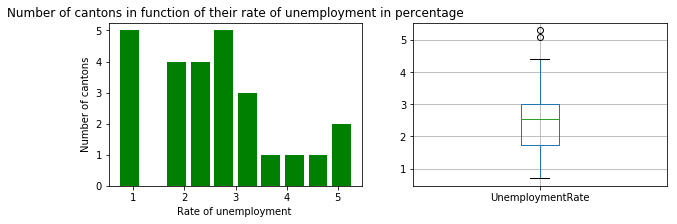

In [24]:
fig3 = plt.figure()
fig3.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(swiss_df['UnemploymentRate'],  align='mid', rwidth = 0.8, color = 'green')
plt.title("Number of cantons in function of their rate of unemployment in percentage")
plt.xlabel("Rate of unemployment ")
plt.ylabel("Number of cantons")

plt.subplot(122)
swiss_df[['UnemploymentRate']].boxplot()
plt.show()

Text(0,0.5,'Unemployment rate (in %)')

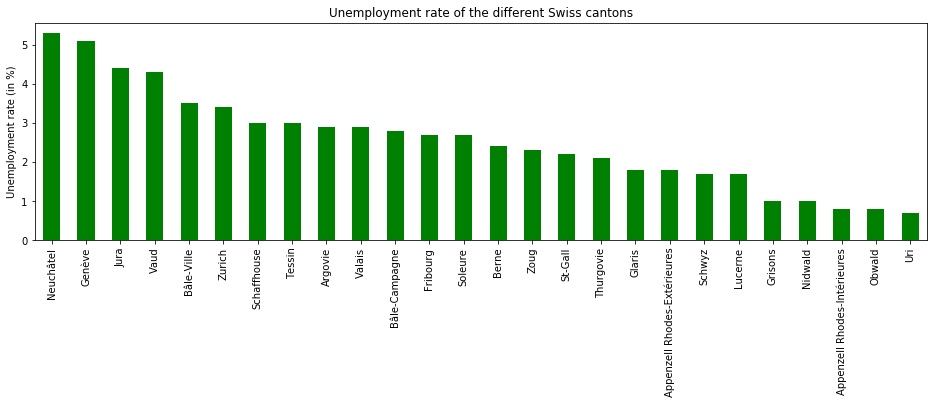

In [25]:
plot = swiss_df.sort_values(by='UnemploymentRate', ascending = False).plot.bar(x='Canton', y='UnemploymentRate', legend = False, figsize=(16,4), color = 'green')
plt.title("Unemployment rate of the different Swiss cantons")
plt.xlabel("")
plt.ylabel("Unemployment rate (in %)")

From the above graphs we see that the minimum percentage is given by the Uri canton with 0.7% and the maximum rate by the Neuchatel canton with 5.3%. The majority of cantons have an unemployment rate between 0% and 3.5%

To be consistent with the previous map, we will keep the 5-step color map with same size intervals and the gradual orange palette for the rate.

In [26]:
swiss_perc_step = cm.StepColormap(['#ffffd4','#fed98e','#fe9929','#d95f0e','#993404'], 
                                  vmin = 0, vmax = 6,  
    caption= 'Percentage of unemployment in Switzerland in July 2017 (in %)')
swiss_perc_step

In [27]:
#Define the color of data in thousand of person data
def swiss_color_function(df, feature, column, step):
    canton = feature['properties']['name']
    tmp_df = df[df['Canton'] == canton]
    #We handle the case of missing values (That is to say a country not in our dataframe)
    if len(tmp_df) > 0:
        value = float(tmp_df[column])
        return step(value)
    else:
       #We select a gray color for unknown value as
        return '#DDDDDD'

#### People Seeking For A Job Stats

Because the unemployment rate in amstat is computed using the amount of person looking for a job (and not the amount of unemployed), we plot the following graphs to have an idea of the number of people seeking for a job we can have (minimum or maximum for example) in the different cantons to allow us to construct our map more easily.

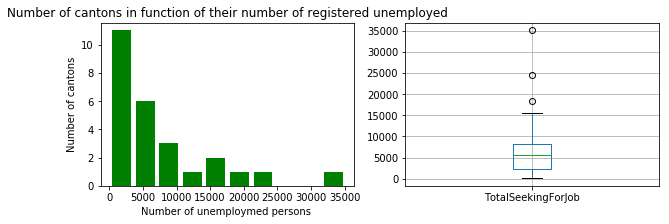

In [28]:
fig4 = plt.figure()
fig4.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(swiss_df['TotalSeekingForJob'],  align='mid', rwidth = 0.8, color = 'green')
plt.title("Number of cantons in function of their number of registered unemployed")
plt.xlabel("Number of unemploymed persons ")
plt.ylabel("Number of cantons")

plt.subplot(122)
swiss_df[['TotalSeekingForJob']].boxplot()
plt.show()

Text(0,0.5,'Unemployed')

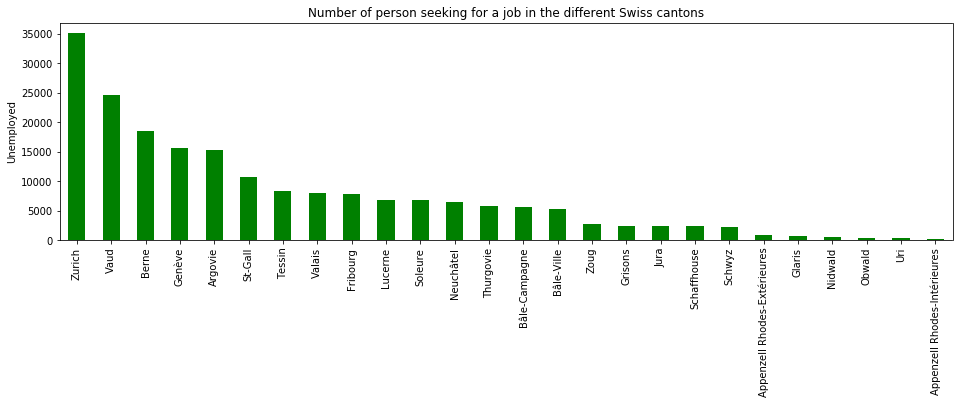

In [29]:
plot = swiss_df.sort_values(by='TotalSeekingForJob', ascending = False).plot.bar(x='Canton', y='TotalSeekingForJob', legend = False, figsize=(16,4), color = 'green')
plt.title("Number of person seeking for a job in the different Swiss cantons")
plt.xlabel("")
plt.ylabel("Unemployed")

From the above graphs we see that the minimum number of people seeking for a job is 103 and given by the AppenzellRhodes-Intérieures canton whereas the maximum by the Zurich canton with 35000 unemployed. The majority of cantons have a number of unemployed below 10 000.

Looking at this data we feel like our usual scale is not working anymore. We will keep the step and the colors but set manually the intervals. <br>
Our strategy will be to change the colors at the quantiles 0.2, 0.4, 0.6 and 0.8.

In [30]:
q1 = swiss_df['TotalSeekingForJob'].quantile(q = 0.2)
q2 = swiss_df['TotalSeekingForJob'].quantile(q = 0.4)
q3 = swiss_df['TotalSeekingForJob'].quantile(q = 0.6)
q4 = swiss_df['TotalSeekingForJob'].quantile(q = 0.8)
print(q1, q2, q3, q4)

915.0 2707.0 6746.0 10608.0


In [31]:
swiss_nb_step = cm.StepColormap(['#ffffd4','#a1dab4','#41b6c4','#2c7fb8', '#253494'], 
                                  vmin = 0, vmax = 35000, index =[0,q1,q2,q3,q4,35000], 
    caption= 'Number of people seeking for a job in Switzerland in July 2017')
swiss_nb_step

We convert now the names from French in the dataframe to match the ones in German in the Topojson file:

In [32]:
canton_matching

{'Appenzell Rhodes-Extérieures': 'Appenzell Ausserrhoden',
 'Appenzell Rhodes-Intérieures': 'Appenzell Innerrhoden',
 'Argovie': 'Aargau',
 'Berne': 'Bern/Berne',
 'Bâle-Campagne': 'Basel-Landschaft',
 'Bâle-Ville': 'Basel-Stadt',
 'Fribourg': 'Fribourg',
 'Genève': 'GenÃ¨ve',
 'Glaris': 'Glarus',
 'Grisons': 'GraubÃ¼nden/Grigioni',
 'Jura': 'Jura',
 'Lucerne': 'Luzern',
 'Neuchâtel': 'NeuchÃ¢tel',
 'Nidwald': 'Nidwalden',
 'Obwald': 'Obwalden',
 'Schaffhouse': 'Schaffhausen',
 'Schwyz': 'Schwyz',
 'Soleure': 'Solothurn',
 'St-Gall': 'St. Gallen',
 'Tessin': 'Ticino',
 'Thurgovie': 'Thurgau',
 'Uri': 'Uri',
 'Valais': 'Valais/Wallis',
 'Vaud': 'Vaud',
 'Zoug': 'Zug',
 'Zurich': 'ZÃ¼rich'}

In [33]:
canton_rate = select_column_df('UnemploymentRate')
canton_number = select_column_df('TotalSeekingForJob')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
m_swiss = folium.Map([47,8], tiles = 'cartodbpositron', zoom_start = 7.4)

folium.TopoJson(
    swiss_json_data,
    'objects.cantons',
    name='Unemployment rate',    
    style_function= lambda feature: {
        'fillColor': swiss_color_function(canton_rate, feature, 'UnemploymentRate', swiss_perc_step),
        'fillOpacity': 0.8,
        'color' : 'grey',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_swiss)
m_swiss.add_child(swiss_perc_step)

folium.TopoJson(
    swiss_json_data,
    'objects.cantons',
    name='People seeking for a job',    
    style_function= lambda feature: {
        'fillColor': swiss_color_function(canton_number, feature, 'TotalSeekingForJob', swiss_nb_step),
        'fillOpacity': 0.8,
        'color' : 'grey',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_swiss)
m_swiss.add_child(swiss_nb_step)

folium.LayerControl(collapsed = False).add_to(m_swiss)
m_swiss

### Part 2

The unemployment rate from amstat is computed by considering the number of person seeking for a job and NOT ONLY the number of unemployed. This rate is biased as the already employed people who are seeking for a (new) job are considered as "unemployed" in the computation of the rate.

This time we ONLY want to consider the unemployed in the computation of the rate. To do so, we need to compute the new rates using the following formula:

$new\_rate$ = $old\_rate \times \frac{unemployed}{total\_seeking\_for\_a\_job}$

In [35]:
swiss_df['Corrected_Rate'] = swiss_df['UnemploymentRate'] * (swiss_df['Unemployed'] / swiss_df['TotalSeekingForJob'])
swiss_df.head()

,Canton,UnemploymentRate,Unemployed,TotalSeekingForJob,EmployedSeekingForJob,Corrected_Rate
0,Zurich,3.4,27992,35112,7120,2.710549
1,Berne,2.4,13633,18442,4809,1.774168
2,Lucerne,1.7,3875,6805,2930,0.968038
3,Uri,0.7,129,265,136,0.340755
4,Schwyz,1.7,1447,2232,785,1.102106


#### New Unemployment Rate Stats

We plot the following graphs to have an idea of the unemployment rates we can have (minimum or maximum for example) in the different cantons to allow us to construct our map more easily:

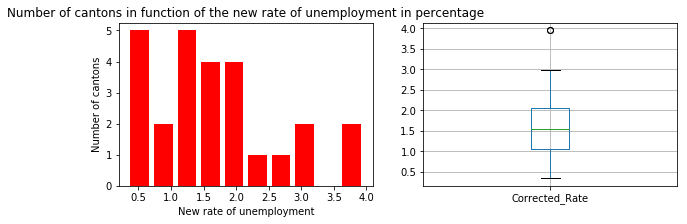

In [36]:
fig5 = plt.figure()
fig5.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(swiss_df['Corrected_Rate'],  align='mid', rwidth = 0.8, color = 'red')
plt.title("Number of cantons in function of the new rate of unemployment in percentage")
plt.xlabel("New rate of unemployment")
plt.ylabel("Number of cantons")

plt.subplot(122)
swiss_df[['Corrected_Rate']].boxplot()
plt.show()

Text(0,0.5,'Unemployment rate (in %)')

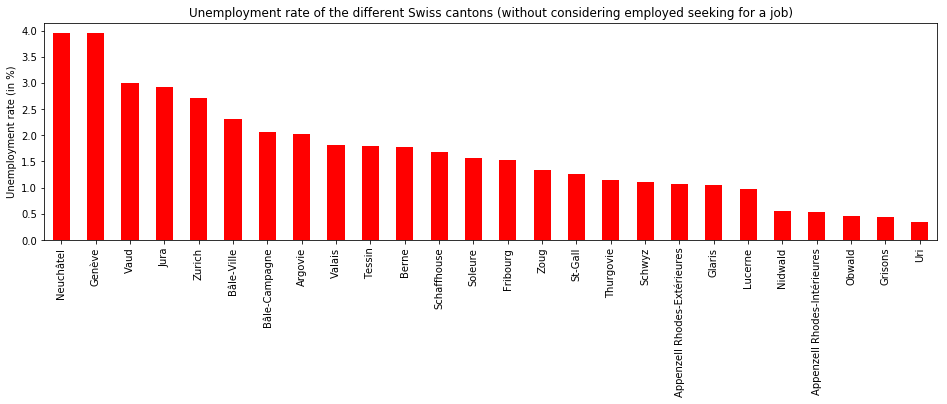

In [37]:
plot = swiss_df.sort_values(by='Corrected_Rate', ascending = False).plot.bar(x='Canton', y='Corrected_Rate', legend = False, figsize=(16,4), color = 'red')
plt.title("Unemployment rate of the different Swiss cantons (without considering employed seeking for a job)")
plt.xlabel("")
plt.ylabel("Unemployment rate (in %)")

This time we see that the minimum percentage is still given by the Uri canton with 0.34% but the maximum rate is given by the Neuchatel (still) and Genève canton with 4.95%. The majority of cantons have an unemployment rate between 0% and 2% (3.5% before). We observe that some cantons are higher in the ranking considering this new rate in comparison with the old one (e.g. Vaud is above Jura with the new rate whereas it was the opposite with the old rate)

In [38]:
swiss_perc_step = cm.StepColormap(['#ffffd4','#fed98e','#fe9929','#d95f0e','#993404'], 
                                  vmin = 0, vmax = 4,  
    caption= 'Percentage of unemployment in Switzerland in July 2017 with new rate (in %)')
swiss_perc_step

#### Unemployed Stats

We plot the following graphs to have an idea of the number of unemloyed people we can have (minimum or maximum for example) in the different cantons to allow us to construct our map more easily:

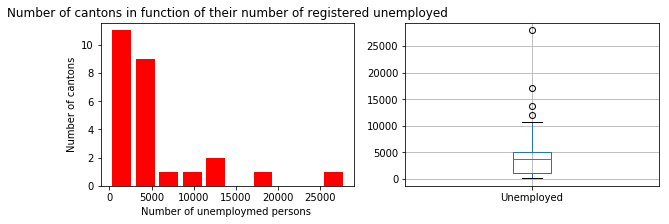

In [39]:
fig6 = plt.figure()
fig6.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(swiss_df['Unemployed'],  align='mid', rwidth = 0.8, color = 'red')
plt.title("Number of cantons in function of their number of registered unemployed")
plt.xlabel("Number of unemploymed persons ")
plt.ylabel("Number of cantons")

plt.subplot(122)
swiss_df[['Unemployed']].boxplot()
plt.show()

Text(0,0.5,'Unemployed')

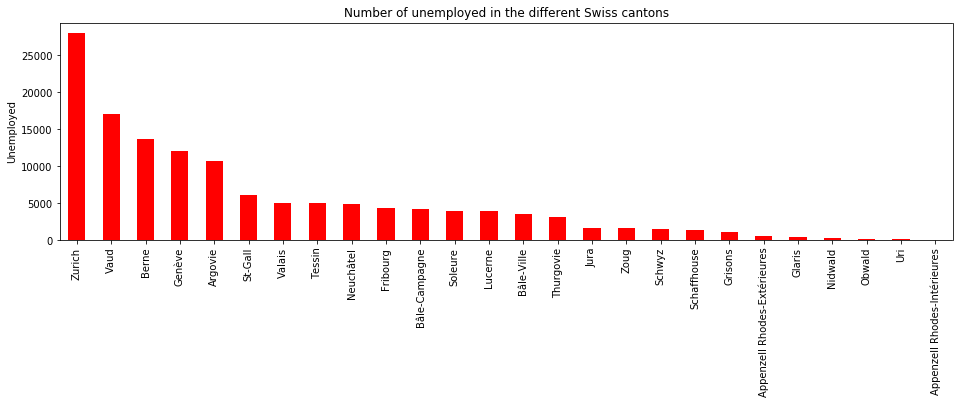

In [40]:
plot = swiss_df.sort_values(by='Unemployed', ascending = False).plot.bar(x='Canton', y='Unemployed', legend = False, figsize=(16,4), color = 'red')
plt.title("Number of unemployed in the different Swiss cantons")
plt.xlabel("")
plt.ylabel("Unemployed")

From the above graphs we see that the minimum number of unemployed is 68 and given by the AppenzellRhodes-Intérieures canton whereasd the maximum by the Zurich canton with 27992 unemployed. The majority of cantons have a number of unemployed below 5000.
Once again, we observe that some cantons are higher in the ranking considering only the unemployed rather than the people seeking for a job (e.g. Neuchatel is above Fribourg in number of unemployed whereas it is the opposite in number of people seeking for a job)

Looking at this data we feel like our usual scale is not working anymore. We will keep the step and the colors but set manually the intervals. <br>
Our strategy will be to change the colors at the quantiles 0.2, 0.4, 0.6 and 0.8.

In [41]:
q1 = swiss_df['Unemployed'].quantile(q = 0.2)
q2 = swiss_df['Unemployed'].quantile(q = 0.4)
q3 = swiss_df['Unemployed'].quantile(q = 0.6)
q4 = swiss_df['Unemployed'].quantile(q = 0.8)
print(q1, q2, q3, q4)

543.0 1603.0 4151.0 6054.0


In [42]:
swiss_nb_step = cm.StepColormap(['#ffffd4','#a1dab4','#41b6c4','#2c7fb8', '#253494'], 
                                  vmin = 0, vmax = 28000, index =[0,q1,q2,q3,q4,28000], 
    caption= 'Number of unemployed in Switzerland in July 2017')
swiss_nb_step

We convert now the names from French in the dataframe to match the ones in German in the Topojson file:

In [43]:
canton_new_rate = select_column_df('Corrected_Rate')
canton_unemployed = select_column_df('Unemployed')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
m_swiss = folium.Map([47,8], tiles = 'cartodbpositron', zoom_start = 7.4)

folium.TopoJson(
    swiss_json_data,
    'objects.cantons',
    name='Unemployment rate',    
    style_function= lambda feature: {
        'fillColor': swiss_color_function(canton_new_rate, feature, 'Corrected_Rate', swiss_perc_step),
        'fillOpacity': 0.8,
        'color' : 'grey',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_swiss)
m_swiss.add_child(swiss_perc_step)

folium.TopoJson(
    swiss_json_data,
    'objects.cantons',
    name='People seeking for a job',    
    style_function= lambda feature: {
        'fillColor': swiss_color_function(canton_unemployed, feature, 'Unemployed', swiss_nb_step),
        'fillOpacity': 0.8,
        'color' : 'grey',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_swiss)
m_swiss.add_child(swiss_nb_step)

folium.LayerControl(collapsed = False).add_to(m_swiss)
m_swiss

We can conclude that changing the way we compute the unemployment rate, by using the amount of people seeking for a job (amstat) or directly using the amount of unemployed, can make significant changes.
For instance, if we look at the real rate of unemployment in Swiss (considering only unemployed): we find that it is 2% instead of 3% which is a huge decrease for this kind 

In [45]:
total['Corrected_Rate'] = total['UnemploymentRate'] * (total['Unemployed'] / total['TotalSeekingForJob'])
total[['Canton', 'UnemploymentRate', 'Corrected_Rate']]

,Canton,UnemploymentRate,Corrected_Rate
26,Total,3.0,2.058046


## Exercice 3

### Introducing Nationality
For this third exercice, we downloaded a file from the amstat.ch website. This file contains the Canton, Nationality and Number of unemployed persons.

In [46]:
#Load data into a dataframe
swiss_nat_df = pd.DataFrame.from_csv('swiss-nat-July17.csv', sep = ';')
#Delete the index on the Canton
swiss_nat_df = swiss_nat_df.reset_index()
#Cast the number of unemployed persons as int
swiss_nat_df['Value'] = swiss_nat_df['Value'].apply(lambda x : x.replace(' ','')).astype(int)
#Here is a preview
swiss_nat_df.head()

,Canton,Nationalité,Mesures,Value
0,Zurich,Etrangers,Chômeurs inscrits,12546
1,Zurich,Etrangers,Demandeurs d'emploi,15950
2,Zurich,Suisses,Chômeurs inscrits,15446
3,Zurich,Suisses,Demandeurs d'emploi,19162
4,Zurich,Total,Chômeurs inscrits,27992


#### Strategy
Our strategy to visualise the difference between the foreigners unemployed and the swiss unemployed is the following one : 

We decided to plot the __percentage of foreigners__ in the unemployed persons of a canton. <br>
Theoretically, this would go from 0% (meaning all unemployed are Swiss) to 100% (meaning all unemployed are foreigners). <br>

In our opinion this is a good way to give the intuition of the repartition of foreigners in the unemployment scheme as we see in glimpse of an eye if the percentage is above or below 50% and so which category is the majority. <br>

We create and edit a sub-dataframe to draw the map easily

In [47]:
#Keep only 'registered unemployed' value
nat_perc_df = swiss_nat_df[swiss_nat_df['Mesures'] == 'Chômeurs inscrits']
#As the value type is the same we can drop this column
nat_perc_df = nat_perc_df.drop(['Mesures'], 1)
#We delete the national total as we only care about cantons
nat_perc_df = nat_perc_df[nat_perc_df['Canton'] != 'Total']
#We compute the percentage for every canton
for c in nat_perc_df.Canton :
    #Retrieve the number of foreigners unemployed
    foreign_nb = nat_perc_df.loc[(nat_perc_df['Nationalité'] == 'Etrangers') &
                (nat_perc_df['Canton'] == c)]['Value']
    #Retrieve the total number of unemployed
    total_nb = nat_perc_df.loc[(nat_perc_df['Nationalité'] == 'Total') &
                (nat_perc_df['Canton'] == c)]['Value']
    #Compute percentage
    proportion = int(foreign_nb)*100/int(total_nb)
    #Add the value to the subdataframe in a new column with a nice rounding
    nat_perc_df.at[nat_perc_df['Canton'] == c, 'Proportion etrangers'] = round(proportion, 2)

#Cleaning of unnecessary columns and rows
#As we have three times the same values, we can keep one line 
#(e.g. chose the lines where the nationality is 'Total')
nat_perc_df = nat_perc_df[nat_perc_df['Nationalité'] == 'Total']
#We keep only the Canton (which is the join Key with the json file) and 
#the percentage we computed
nat_perc_df = nat_perc_df[['Canton', 'Proportion etrangers']]
#We apply the matching of canton names from the dataframe to the json values
nat_perc_df['Canton'] = nat_perc_df['Canton'].apply(lambda c : canton_matching[c])
#Here is a preview
nat_perc_df.head()

,Canton,Proportion etrangers
4,ZÃ¼rich,44.82
10,Bern/Berne,36.02
16,Luzern,41.06
22,Uri,53.49
28,Schwyz,43.54


In order to set our color map correctly we explore the data by plotting the values and making a boxplot.

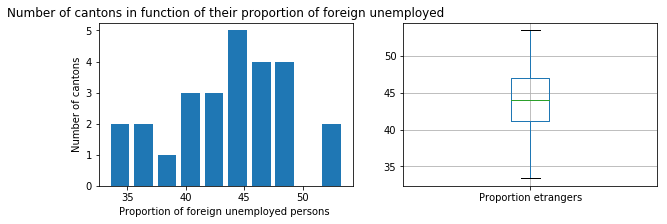

In [48]:
fig5 = plt.figure()
fig5.set_size_inches(10, 3)

plt.subplot(121)
plt.hist(nat_perc_df['Proportion etrangers'],  align='mid', rwidth = 0.8)
plt.title("Number of cantons in function of their proportion of foreign unemployed")
plt.xlabel("Proportion of foreign unemployed persons ")
plt.ylabel("Number of cantons")

plt.subplot(122)
nat_perc_df.boxplot()
plt.show()

Text(0,0.5,'Foreigners')

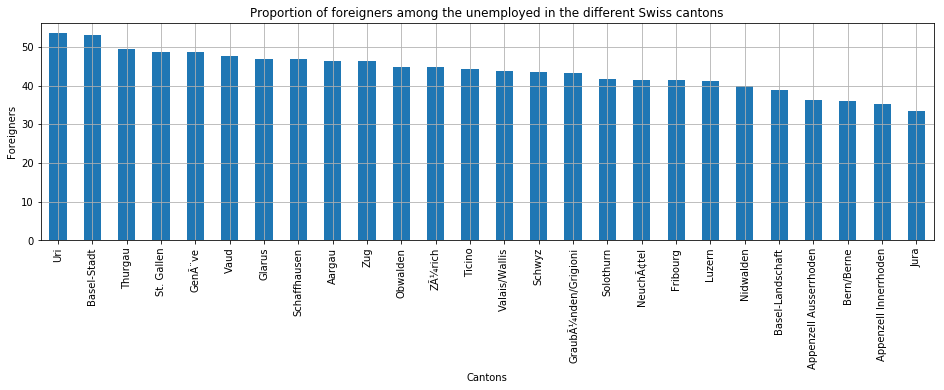

In [51]:
plot = nat_perc_df.sort_values(by='Proportion etrangers', ascending = False).plot.bar(x='Canton', y='Proportion etrangers', legend = False, figsize=(16,4), grid=True)
plt.title("Proportion of foreigners among the unemployed in the different Swiss cantons")
plt.xlabel("Cantons")
plt.ylabel("Foreigners")

From the above graph, we see that all the cantons have between 30 and 50% of foreigners among their unempoyed population.

We chose to make some step colormap. The colors will be centered at 50% (which means there are the same number of foreigners and swiss unemployed persons), the interval [49, 51] will be in white. Percentages below will be in green and above in orange. As we are using percentages we should go from 0 to 100 and discard the min and max values of our data.

In [52]:
swiss_nat_perc_step = cm.StepColormap(['#018571','#80cdc1','#f5f5f5','#dfc27d','#a6611a'], 
                                  vmin = 0, vmax = 100, index = [0,30,49,51,70,100], 
    caption= 'Percentage of foreign unemployed in Switzerland in July 2017')
swiss_nat_perc_step

In [53]:
m_swiss2 = folium.Map([47,8], tiles = 'cartodbpositron', zoom_start = 7.4)

folium.TopoJson(
    swiss_json_data,
    'objects.cantons',
    name='foreign unemployment',    
    style_function= lambda feature: {
        'fillColor': swiss_color_function(nat_perc_df, feature, 'Proportion etrangers', swiss_nat_perc_step),
        'color' : 'grey',
        'fillOpacity' : 0.8,
        'weight' : 1,
        'dashArray' : '1, 1'
        }
).add_to(m_swiss2)
m_swiss2.add_child(swiss_nat_perc_step)

m_swiss2

In [54]:
nat_perc_df[nat_perc_df['Proportion etrangers'] ==nat_perc_df['Proportion etrangers'].max()]

,Canton,Proportion etrangers
22,Uri,53.49


In [55]:
nat_perc_df[nat_perc_df['Proportion etrangers'] ==nat_perc_df['Proportion etrangers'].min()]

,Canton,Proportion etrangers
154,Jura,33.37


The biggest differences are in Uri (53.49% of foreigner unemployment) and in Jura (33.37% of foreigner unemployment). <br>
We think that as Jura has a large frontier with France, most of the foreigner workers would come from France and if they are unemployed they would be registered in the French system not in the Swiss system. <br>
About Uri, one could think that has one of the first cantons of Switzerland, they are very proud of their nation and would prefer hire Swiss people. <br>
### Adding age in the picture
For this part we had to go find an other file on the amstat.ch website. <br>
This new file contains the Canton, the Age Category, the Nationality and the Number of unemployed persons.

In [56]:
#Setting the dataframe
swiss_nat_age_df = pd.DataFrame.from_csv('swiss-nat-age-July17.csv', sep = ';')
#Parsing the Values into integers
swiss_nat_age_df['Chômeurs inscrits'] = swiss_nat_age_df['Chômeurs inscrits'].apply(lambda x : x.replace(' ', '')).astype(int)
#Changing column names
swiss_nat_age_df = swiss_nat_age_df.rename(index = str, columns = {'Classes d\'âge par étapes de 5 ans' : 'Age', 'Chômeurs inscrits' : 'Value'})
#Delete the index
swiss_nat_age_df = swiss_nat_age_df.reset_index()
#Delete the total by Canton (when Age is Total)
swiss_nat_age_df = swiss_nat_age_df[swiss_nat_age_df['Age'] != 'Total']
#Delete the rows when the Nationality is 'Suisses' as we don't need to compute the percentage
swiss_nat_age_df = swiss_nat_age_df[swiss_nat_age_df['Nationalité'] != 'Suisses']
#Here is a preview
swiss_nat_age_df.head()

,Canton,Age,Nationalité,Value
0,Zurich,15-19 ans,Etrangers,453
2,Zurich,15-19 ans,Total,1262
3,Zurich,20-24 ans,Etrangers,631
5,Zurich,20-24 ans,Total,2068
6,Zurich,25-29 ans,Etrangers,1515


In [57]:
#We create a new dataframe for our computation with the only 3 columns that we want
res_df = pd.DataFrame(columns = ['Canton', 'Age', 'Proportion etrangers'])
#We retrieve all the different age class present in the dataframe
age_classes = swiss_nat_age_df.Age.unique()
#We compute the percentage of foreigners unemployed for each canton
for c in swiss_nat_age_df.Canton.unique() :
    #We compute the percentage of foreigners unemployed for each canton in given Canton
    for age in age_classes:
        #We retrieve the number of unemployed foreigners
        foreign_nb = swiss_nat_age_df.loc[(swiss_nat_age_df['Nationalité'] == 'Etrangers') &
                    (swiss_nat_age_df['Canton'] == c) & (swiss_nat_age_df['Age'] == age)]['Value']
        #We retrieve the total number of unemployed
        total_nb = swiss_nat_age_df.loc[(swiss_nat_age_df['Nationalité'] == 'Total') &
                    (swiss_nat_age_df['Canton'] == c) & (swiss_nat_age_df['Age'] == age)]['Value']
        try : 
            #Compute the percentage
            proportion = int(foreign_nb)*100/int(total_nb) 
        except TypeError:
            #In case some canton has a missing value for some age category
            print(c, age)
        #Add the row in the result dataframe
        res_df.loc[len(res_df)] = [c,age,round(proportion, 2)]
        
#Matching of canton names with our previous values
res_df['Canton'] = res_df['Canton'].apply(lambda c : canton_matching[c])
#Here is a preview
res_df.head()

Obwald 15-19 ans
Appenzell Rhodes-Intérieures 15-19 ans


,Canton,Age,Proportion etrangers
0,ZÃ¼rich,15-19 ans,35.90
1,ZÃ¼rich,20-24 ans,30.51
2,ZÃ¼rich,25-29 ans,46.70
3,ZÃ¼rich,30-34 ans,56.04
4,ZÃ¼rich,35-39 ans,57.03


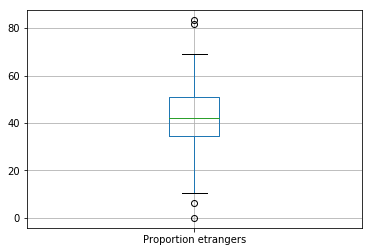

In [58]:
#In order to have insight on our data, we do a boxplot
res_df.boxplot()

We will use the same color map as the previous question with the percentages. However as we draw barplots instead of a choropleth map, we replaced the 'white' color by some 'gray' in order to see the bars.

In [59]:
swiss_nat_age_step = cm.StepColormap(['#018571','#80cdc1','#DDDDDD','#dfc27d','#a6611a'], 
                                  vmin = 0, vmax = 100, index = [0,30,45,55,70,100], 
    caption= 'Percentage of foreign unemployed in Switzerland in July 2017')
swiss_nat_age_step

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


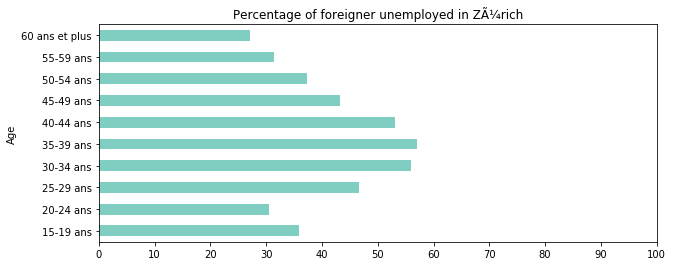

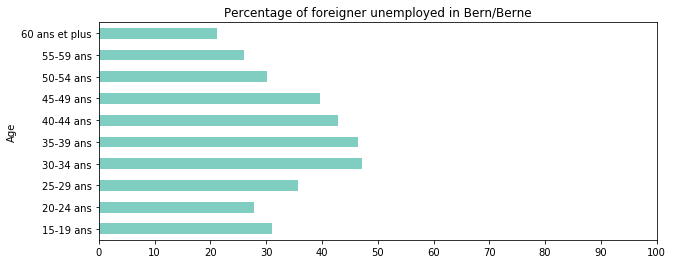

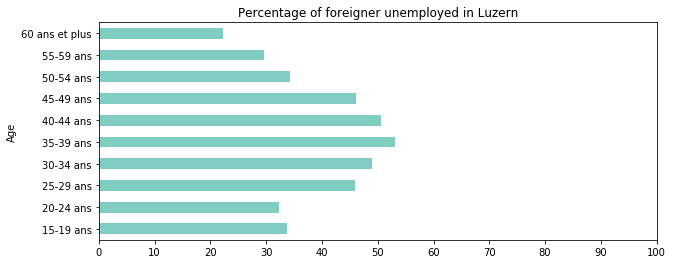

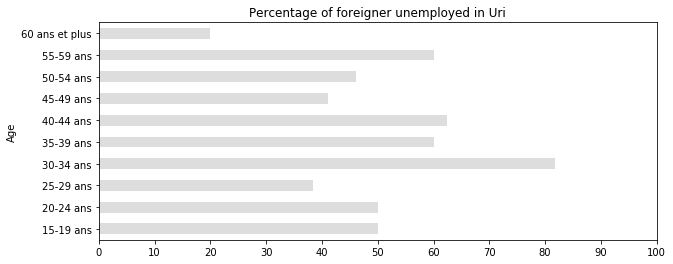

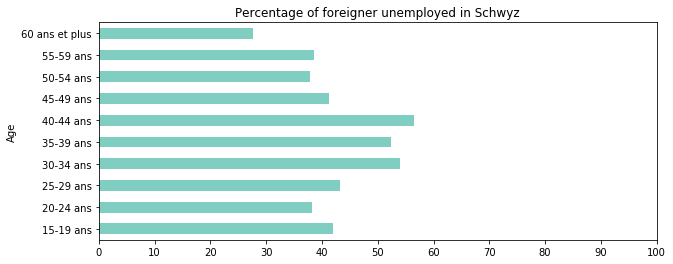

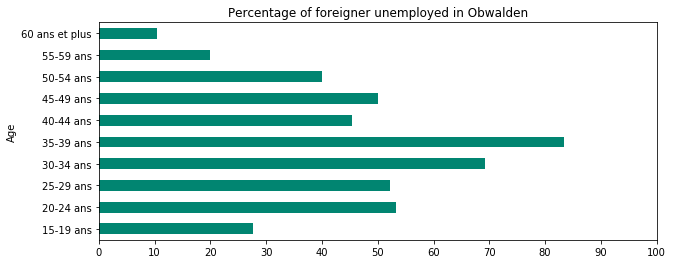

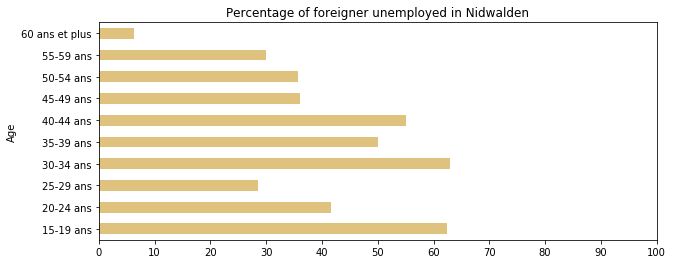

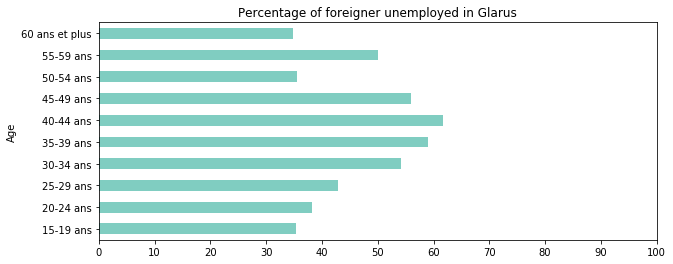

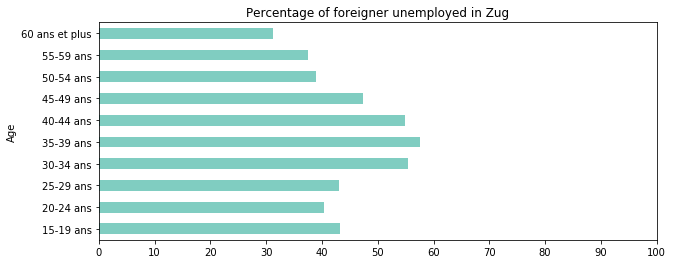

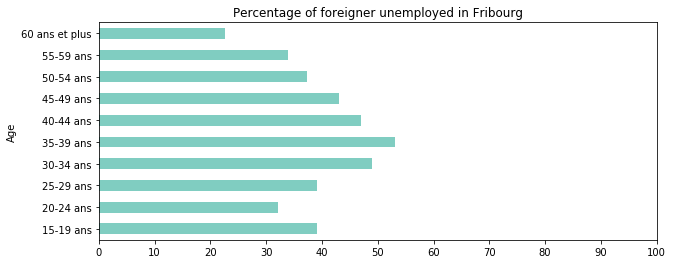

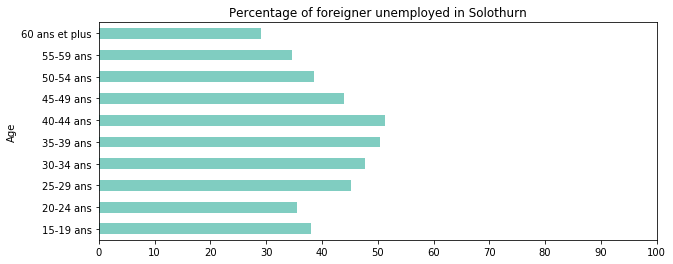

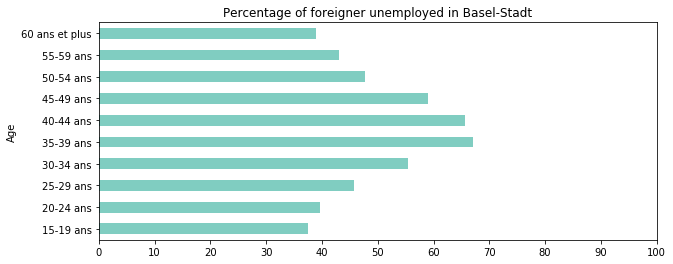

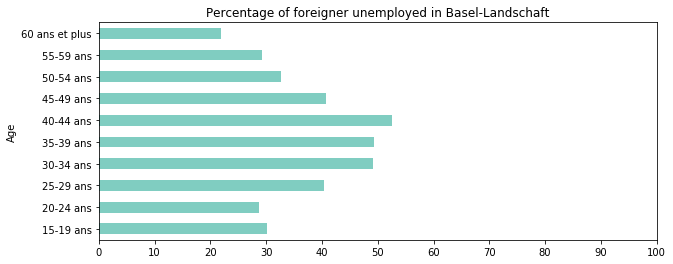

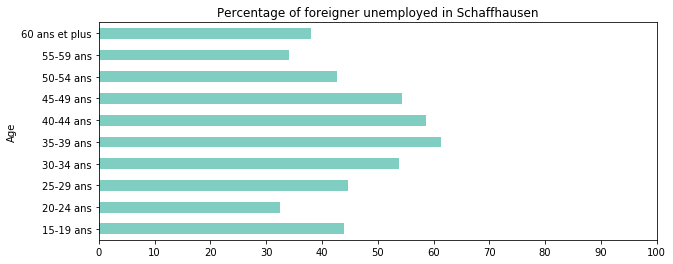

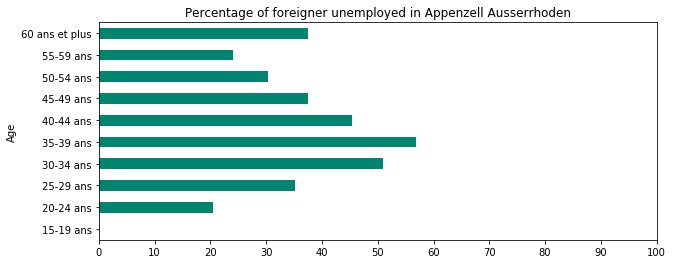

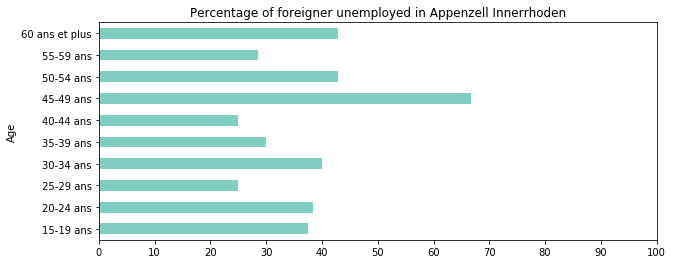

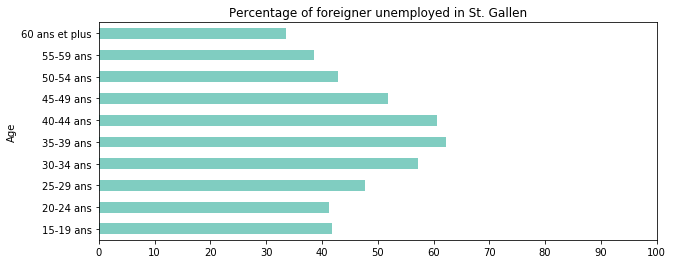

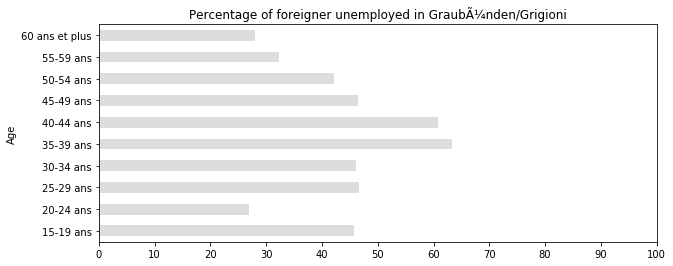

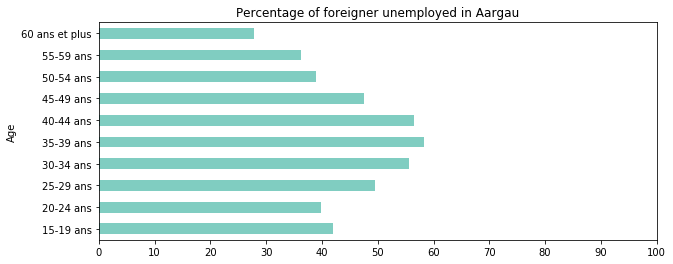

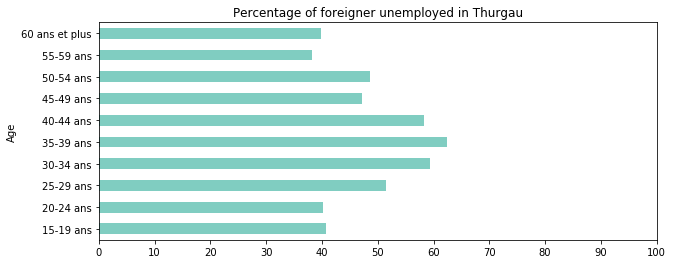

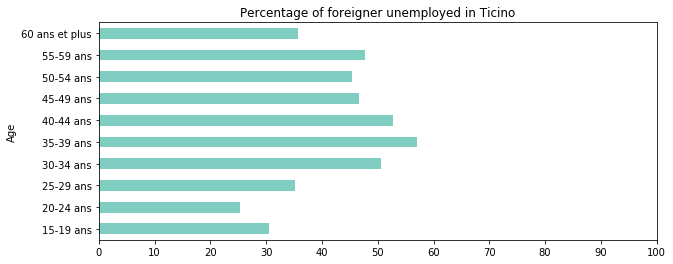

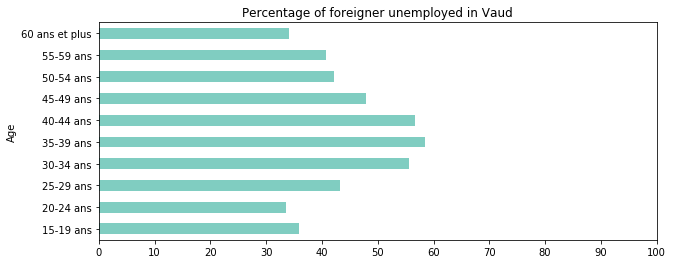

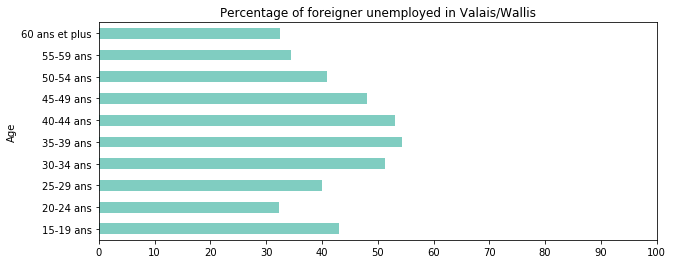

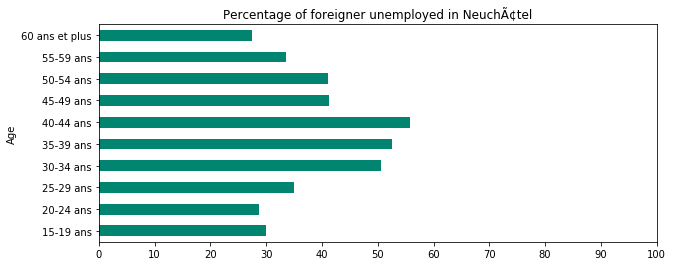

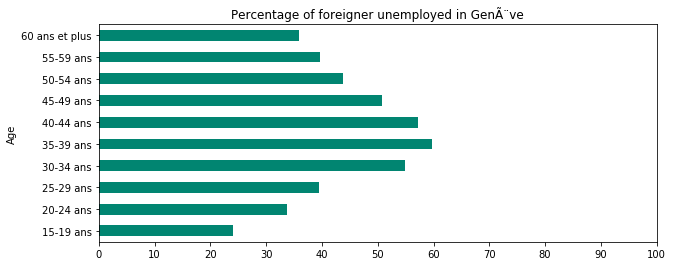

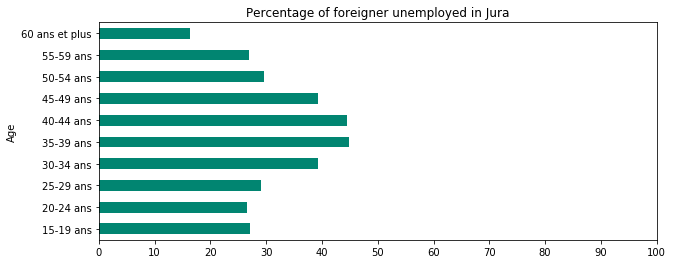

In [60]:
#We will draw the barplots by canton
for c in res_df.Canton.unique():
    #Select the data of current canton
    tmp_df = res_df[res_df['Canton'] == c]
    #Get the interesting columns
    tmp_df = tmp_df[['Age', 'Proportion etrangers']]
    #Add the color to the data accordingly to our colormap
    tmp_df['color'] = tmp_df['Proportion etrangers'].apply(lambda p : swiss_nat_age_step(p))
    #Do an horizontal bar plot, set the ticks from 0 to 100 for an easier comparison
    tmp_df.plot(x='Age', y = 'Proportion etrangers', figsize = (10, 4),
                kind = 'barh', legend = False, title = 'Percentage of foreigner unemployed in '+c,
               xticks = np.arange(0, 110, 10), color = tmp_df.color)